### Accessing Dataset From Google Drive 

Mounting GDrive and specifying path for the same

In [ ]:
from pathlib import Path
import os
import numpy as np
from google.colab import drive

drive.mount('/content/gdrive')
path = Path("/content/gdrive/My Drive/Colab Notebooks/datasetimg/Google Images")

In [2]:
data_list = os.listdir(path)
data_list

['Burj Khalifa - UAE',
 'Eiffel Tower - Paris',
 'Machu Pichu',
 'Great Wall Of China - China',
 'Himalaya - India',
 'Christ the Reedemer Statue',
 'Chich-n Itz - Mexico',
 'Antarctica',
 'Giant-s Causeway',
 'The Blue Grotto - Capri',
 'Stonehenge',
 'Niagara Falls',
 'Taj Mahal - India',
 'Pyramids Of Giza - Egypt',
 'Venezuela Angel Falls',
 'Santorini',
 'Roman Colosseum - Rome',
 'Statue Of Liberty - NYC']

In [3]:
data_list.sort()
print(data_list)

['Antarctica', 'Burj Khalifa - UAE', 'Chich-n Itz - Mexico', 'Christ the Reedemer Statue', 'Eiffel Tower - Paris', 'Giant-s Causeway', 'Great Wall Of China - China', 'Himalaya - India', 'Machu Pichu', 'Niagara Falls', 'Pyramids Of Giza - Egypt', 'Roman Colosseum - Rome', 'Santorini', 'Statue Of Liberty - NYC', 'Stonehenge', 'Taj Mahal - India', 'The Blue Grotto - Capri', 'Venezuela Angel Falls']


In [0]:
import cv2
import glob
import tensorflow as tf
from scipy.misc import *
from tqdm import tqdm
from PIL import Image
from numpy import*
data=[]

Convert all images into gray scale array values 

In [5]:
for category in data_list:
    path_ = os.path.join(path,category)
    for img in tqdm(os.listdir(path_)):
        img_array = cv2.imread(os.path.join(path_,img) ,cv2.IMREAD_GRAYSCALE)
        data.append([img_array,category])

100%|██████████| 138/138 [01:19<00:00,  1.68it/s]


Now data is in same repetitive pattern model will mislead its learning due this, hence shuffle data to avoid any circumstance

In [0]:
import random

random.shuffle(data)

Seperating feature and label 

In [7]:
features = []
labels = []

for feat,label in data:
    features.append(feat)
    labels.append(label)

print(labels) 


['Pyramids Of Giza - Egypt', 'Taj Mahal - India', 'Machu Pichu', 'Taj Mahal - India', 'Antarctica', 'Stonehenge', 'Venezuela Angel Falls', 'Eiffel Tower - Paris', 'Stonehenge', 'Niagara Falls', 'Machu Pichu', 'The Blue Grotto - Capri', 'Venezuela Angel Falls', 'Taj Mahal - India', 'Eiffel Tower - Paris', 'Venezuela Angel Falls', 'Pyramids Of Giza - Egypt', 'Giant-s Causeway', 'Machu Pichu', 'Chich-n Itz - Mexico', 'Roman Colosseum - Rome', 'Antarctica', 'Great Wall Of China - China', 'Giant-s Causeway', 'Statue Of Liberty - NYC', 'Christ the Reedemer Statue', 'Antarctica', 'Giant-s Causeway', 'Christ the Reedemer Statue', 'Chich-n Itz - Mexico', 'Machu Pichu', 'Pyramids Of Giza - Egypt', 'Eiffel Tower - Paris', 'Venezuela Angel Falls', 'Antarctica', 'Stonehenge', 'Niagara Falls', 'Christ the Reedemer Statue', 'Giant-s Causeway', 'Taj Mahal - India', 'Himalaya - India', 'Himalaya - India', 'Eiffel Tower - Paris', 'Stonehenge', 'Statue Of Liberty - NYC', 'Burj Khalifa - UAE', 'Niagara Fa

Using label encoder to convert categorical data into numerical 

In [8]:
from sklearn import preprocessing 
label=[]
label = np.asarray(labels)
labels=[] 
label_encoder = preprocessing.LabelEncoder() 
labels= label_encoder.fit_transform(label)

print(labels[:30])

[10 15  8 15  0 14 17  4 14  9  8 16 17 15  4 17 10  5  8  2 11  0  6  5
 13  3  0  5  3  2]


Image size may vary so resize image into 250 X 250 

In [0]:
img_array=[]
i=[]
width = 250
height = 250
for i in features:
    resized = cv2.resize(i,(width,height), interpolation=cv2.INTER_CUBIC)
    img_array.append(resized)

Reshaping

In [0]:
img_array = np.asarray(img_array)
img_array = img_array.reshape(len(img_array),250,250,1)

Let's save the structure of model till now in pickle

In [0]:
import pickle
x = open("feat.pickle","wb")
pickle.dump(img_array, x)
x.close()

Y = open("label.pickle","wb")
pickle.dump(labels, Y)
Y.close()

Open dumped pickle file

In [0]:
import pickle
pickle_in = open("feat.pickle","rb")
feature = pickle.load(pickle_in)

pickle_in = open("label.pickle","rb")
label = pickle.load(pickle_in)

[Rescale images](https://datascience.stackexchange.com/questions/29958/when-inputting-image-rgb-values-to-mlp-should-i-divide-by-255)

In [0]:
feature = img_array/255.0

Splitting features and label into training and validation set 

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_val, Y_train, Y_val = train_test_split(feature, labels , test_size = 0.2, random_state=42)

In [0]:

from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10, # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally 
        height_shift_range=0.1,  # randomly shift images vertically 
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagen.fit(X_train)  # fitting X_train 

In [16]:

import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D

model = Sequential()

model.add(Conv2D(180,kernel_size=(3,3),activation='relu',input_shape=(250,250,1)))
model.add(Conv2D(150,kernel_size=(3,3),activation='relu'))
model.add(MaxPooling2D(5,5))
model.add(Dropout(rate=0.3))   
model.add(Conv2D(110,kernel_size=(3,3),activation='relu'))
model.add(MaxPooling2D(5,5))
model.add(Conv2D(80,kernel_size=(3,3),activation='relu'))
model.add(Flatten())
model.add(Dense(80,activation='relu'))
model.add(Dense(60,activation='relu'))
model.add(Dropout(rate=0.3))
model.add(Dense(45,activation='relu'))
model.add(Dropout(rate=0.5))
model.add(Dense(18,activation='softmax'))

model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


ReduceLROnPlateau provide feature of updating learning rate whenever training score is not progressing forward

In [0]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc',   # quality to be monitored 
                                            patience=3,          # no improvement after learning rate will be reduced
                                            verbose=1,           # update message
                                            factor=0.5,          # reducing learning rate 
                                            min_lr=0.00005)      # learning rate

In [31]:
fitting = model.fit_generator(datagen.flow(X_train, Y_train, batch_size = 45),
                              epochs = 30, validation_data = (X_val, Y_val),
                              verbose = 1, callbacks = [learning_rate_reduction])

Epoch 1/30
52/52 [==============================] - 58s 1s/step - loss: 1.4388 - acc: 0.5157 - val_loss: 1.4734 - val_acc: 0.5258
Epoch 2/30
52/52 [==============================] - 60s 1s/step - loss: 1.4375 - acc: 0.5222 - val_loss: 1.4739 - val_acc: 0.5189
Epoch 3/30
52/52 [==============================] - 61s 1s/step - loss: 1.4492 - acc: 0.5282 - val_loss: 1.4721 - val_acc: 0.5275
Epoch 4/30
52/52 [==============================] - 61s 1s/step - loss: 1.4503 - acc: 0.5166 - val_loss: 1.4800 - val_acc: 0.5258
Epoch 5/30
52/52 [==============================] - 61s 1s/step - loss: 1.4766 - acc: 0.5105 - val_loss: 1.4673 - val_acc: 0.5206
Epoch 6/30
51/52 [============================>.] - ETA: 1s - loss: 1.4229 - acc: 0.5193
Epoch 00006: ReduceLROnPlateau reducing learning rate to 5e-05.
52/52 [==============================] - 61s 1s/step - loss: 1.4190 - acc: 0.5226 - val_loss: 1.4735 - val_acc: 0.5223
Epoch 7/30
52/52 [==============================] - 61s 1s/step - loss: 1.4354

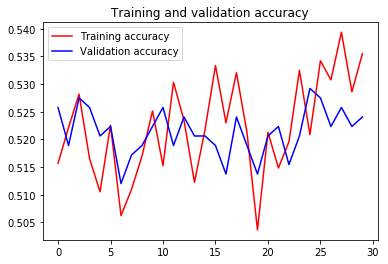

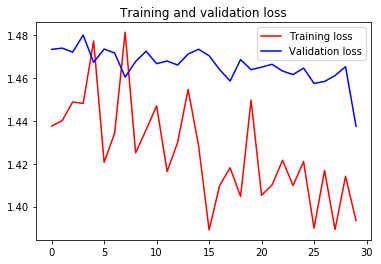

In [39]:
import matplotlib.pyplot as plt
%matplotlib inline

accuracy = fitting.history['acc']
val_accuracy = fitting.history['val_acc']
loss = fitting.history['loss']
val_loss = fitting.history['val_loss']
epochs = range(len(accuracy))

plt.plot(epochs, accuracy, 'b', color="red", label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'b', color="red", label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()